In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import csv
import warnings
import statsmodels.api as sm

In [2]:
warnings.filterwarnings("ignore")

In [3]:
def plot_columns(df):
    colors = plt.cm.tab20(range(df.shape[1]))  

    for i, column in enumerate(df.columns):
        color = colors[i % 24]

        plt.figure()
        plt.plot(df.index, df[column], color=color)
        plt.xlabel('Tempo')
        plt.ylabel('Valor')
        plt.title(column)

    plt.show()
    
def plot_linear_regression(column, linear_a, linear_b, linear_a_half, linear_b_half):
    plt.figure(figsize=(10, 6))
    plt.scatter(column.index, column, label='Original Values')
    plt.plot(column.index, linear_a * column.index + linear_b, color='red', label='Linear Regression')
    plt.plot(column.index, linear_a_half * column.index + linear_b_half, color='green', label='Recent Linear Regression')
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.legend()
    plt.title('Original Values vs. Linear Regression vs. Recent Linear Regression')
    plt.grid(True)
    plt.show()

In [4]:
def centered_moving_average(column, window_action, window_size):
    start_index, end_index = window_action
    data = column.to_numpy()

    data_length = len(data)

    for i in range(start_index, end_index + 1):
        if not np.isnan(data[i]):
            init = data[i]
            start = max(0, i - window_size)
            end = min(data_length, i + window_size + 1)
            window = data[start:end]
            valid_values = [value for value in window if not pd.isna(value)]
            if len(valid_values) > 0:
                data[i] = np.mean(valid_values)

    modified_column = pd.Series(data, name=column.name)

    return modified_column

In [5]:
# Polynomial Interpolation data inputation method
def four_ends_filler(column):
    if  pd.api.types.is_numeric_dtype(column):
        for i in range(4):
            column = first_filler(column, i, len(column) - 1 - i)
            column = last_filler(column, i, len(column) - 1 - i)
    return column

def four_ends_linear_filler(column):
    if  pd.api.types.is_numeric_dtype(column):
        size = len(column) - 1
        column = first_filler(column, 0, size)
        column = last_filler(column, 0, size)
        for i in range(1, 4):
            value = column.at[i]
            if (pd.isnull(value) or np.isnan(value) or (value == '')):
                start_first = i - 1
                end_first = next_valid_index(column, i)
                linear_a = (column.at[end_first] - column.at[i - 1])/(end_first - start_first)
                linear_b = column.at[start_first] - linear_a*start_first
                column.at[i] = linear_a*i + linear_b
            x = size - 4 + i
            value = column.at[x]
            if (pd.isnull(value) or np.isnan(value) or (value == '')):
                start_last = prev_valid_index(column, x)
                end_last = next_valid_index(column, x)
                gap = list(range(start_last + 1, end_last))
                linear_a = (column.at[end_last] - column.at[start_last])/(end_last - start_last)
                linear_b = column.at[start_last] - linear_a*start_last
                column.at[x] = linear_a*x + linear_b
    return column

def first_filler(column, init, end):
    if pd.isnull(column.at[init]) or np.isnan(column.at[init]):
        first_valid_index = 0
        while first_valid_index <= end and (pd.isnull(column.at[first_valid_index]) or 
                                             np.isnan(column.at[first_valid_index])):
            first_valid_index += 1
        if first_valid_index > end:
            column.at[init] = 0.0
        else:
            column.at[init] = column.at[first_valid_index]
    return column

def extract_valid_values(column):
    valid_values = []
    valid_indexes = []
    for index, value in enumerate(column):
        if not pd.isnull(value) and not np.isnan(value):
            valid_values.append(value)
            valid_indexes.append(index)
    extracted_column = pd.Series(
        valid_values,
        index=valid_indexes
    )
    return extracted_column

def linear_regression_first_four_filler(column):
    size = len(column) - 1
    processed_column = extract_valid_values(column)
    mean_valid_values_quarter = processed_column.mean()/4
    mean_valid_values_quarter_upper = processed_column.mean() + mean_valid_values_quarter
    
    model = sm.OLS(processed_column, sm.add_constant(processed_column.index))
    result = model.fit()
    linear_a = result.params[1]
    linear_b = result.params['const']
    half_column = processed_column[:(len(processed_column) // 2)]
    model2 = sm.OLS(half_column, sm.add_constant(half_column.index))
    result2 = model2.fit()
    linear_a_half = result2.params[1]
    linear_b_half = result2.params['const']
    
    for i in range(0,4):
        if pd.isnull(column.at[i]) or np.isnan(column.at[i]):
            projected = ((linear_a*i + linear_b) + (linear_a_half*i + linear_b_half))/2
            if projected < mean_valid_values_quarter:
                column.at[i] = mean_valid_values_quarter
            elif projected > mean_valid_values_quarter_upper:
                column.at[i] = mean_valid_values_quarter_upper
            else:
                column.at[i] = projected
        x = size - 4 + i
        if pd.isnull(column.at[x]) or np.isnan(column.at[x]):
            projected = ((linear_a*i + linear_b) + (linear_a_half*i + linear_b_half))/2
            if projected < mean_valid_values_quarter:
                column.at[x] = mean_valid_values_quarter
            elif projected > mean_valid_values_quarter_upper:
                column.at[x] = mean_valid_values_quarter_upper
            else:
                column.at[x] = projected
    plot_linear_regression(column, linear_a, linear_b, linear_a_half, linear_b_half)
    return column
    
def last_filler(column, init, end):
    if pd.isnull(column.at[end]) or np.isnan(column.at[end]):
        last_valid_index = len(column) -1
        while last_valid_index >= init and (pd.isnull(column.at[last_valid_index]) or 
                                         np.isnan(column.at[last_valid_index])):
            last_valid_index -= 1
        if last_valid_index < init:
            column.at[end] = 0.0
        else:
            column.at[end] = column.at[last_valid_index]
    return column
  
def neareast_four_indexes(column, start, end):
    return prev_four_valid_indexes(column, start) + next_four_valid_indexes(column, end)

def prev_four_valid_indexes(column, pos):
    prev_index = pos
    index_prev_list = [0]*4
    size = len(column) - 1
    if pos > 0 and pos < size:
        for i in range(4):
            index_prev_list[3 - i] = prev_index
            prev_index -= 1
            while prev_index >= 0 and (pd.isnull(column.at[prev_index]) or np.isnan(column.at[prev_index])):
                prev_index -= 1
    return index_prev_list  

def next_four_valid_indexes(column, pos):
    next_index = pos
    index_next_list = [0]*4
    size = len(column) - 1
    if pos > 0 and pos < size:
        for i in range(4):
            index_next_list[i] = next_index
            next_index += 1
            while next_index <= size and (pd.isnull(column.at[next_index]) or np.isnan(column.at[next_index])):
                next_index += 1
    return index_next_list  

def prev_valid_index(column, pos):
    prev_index = pos
    size = len(column) -1
    if pos >= 0 and pos < size:
        prev_index -= 1
        while prev_index >= 0 and (pd.isnull(column.at[prev_index]) or np.isnan(column.at[prev_index])):
            prev_index -= 1
    return prev_index  

def next_valid_index(column, pos):
    next_index = pos
    size = len(column) -1
    if pos >= 0 and pos < size:
        next_index += 1
        while next_index <= size and (pd.isnull(column.at[next_index]) or np.isnan(column.at[next_index])):
            next_index += 1
    return next_index

def interpolating_polynomial(nearest_indexes, nearest_values):
    coeffs = np.polyfit(nearest_indexes, nearest_values, 3)
    return np.poly1d(coeffs)

def polynomial_filler(column):
    size = len(column) -1
    if column.isnull().any() and column.isna().any():
        for i, value in enumerate(column):
            if (i > 3 and i < size - 3) and (pd.isnull(value) or np.isnan(value) or (value == '')):
                nearest_values = []
                start = prev_valid_index(column, i)
                end = next_valid_index(column, i)
                gap = list(range(start + 1, end))
                nearest_indexes = neareast_four_indexes(column, start, end)
                for index in nearest_indexes:
                    nearest_values.append(column.at[index])
                polynomial = interpolating_polynomial(nearest_indexes, nearest_values)
                for x in gap:
                    column.at[x] = polynomial(x)
                plot_polynomial(polynomial, nearest_indexes[0], nearest_indexes[len(nearest_indexes) - 1], 50, gap, nearest_indexes, column.name)
    return column

def plot_polynomial(polynomial, start, end, precision, interpolated_list, nearest_indexes, column_name):
    x = np.linspace(start, end, precision)
    y = polynomial(x)

    plt.figure()

    plt.plot(x, y)

    interpolated_x = interpolated_list  
    interpolated_y = polynomial(interpolated_x)
    plt.scatter(interpolated_x, interpolated_y, color='red')
    interpolated_x = nearest_indexes  
    interpolated_y = polynomial(interpolated_x)
    plt.scatter(interpolated_x, interpolated_y, color='green')
    
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(column_name)

    plt.show()
    
def replace_negative_with_float_zeros(x):
    return 0.0 if x < 0 else x

In [6]:
def insert_empty_rows(df, init, end):
    blank_years = list(range(init, end))
    empty_rows = [pd.DataFrame({'Year': [year] + [''] * (df.shape[1] - 1)}) for year in blank_years]
    df = pd.concat([pd.DataFrame({'Year': [year]}) for year in years_to_insert] + [df], ignore_index=True)
    df = df.sort_values(by='Year').reset_index(drop=True)

    return df

In [7]:
def read_csv_replace_missing_by_polynomial(file_path, skiped_rows, skiped_columns):
    with open(file_path, 'r') as f:
        
        df = pd.read_csv(file_path, skiprows=skiped_rows)
        
        i = 0
        for col in df.columns: # Elimina missing values por médias e transforma em float
            if i > skiped_columns:
                df[col] = df[col].replace('-9999', np.nan)
                df[col] = df[col].replace('-', np.nan)
                df[col] = df[col].replace('', np.nan).astype(float)
                df[col] = linear_regression_first_four_filler(df[col])
                df[col] = centered_moving_average(df[col], (0, len(df[col]) - 1), 3) #3 meses
                df[col] = polynomial_filler(df[col])
                df[col] = df[col].apply(replace_negative_with_float_zeros)
            i += 1
        return df

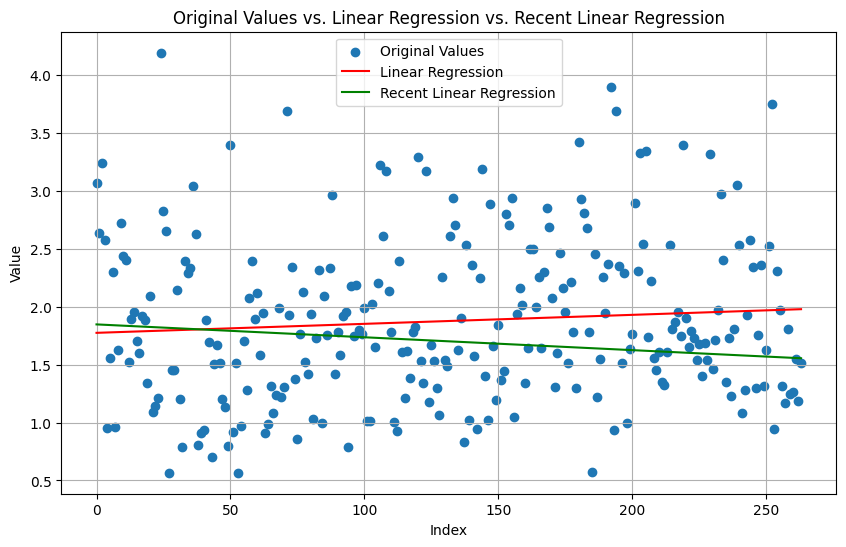

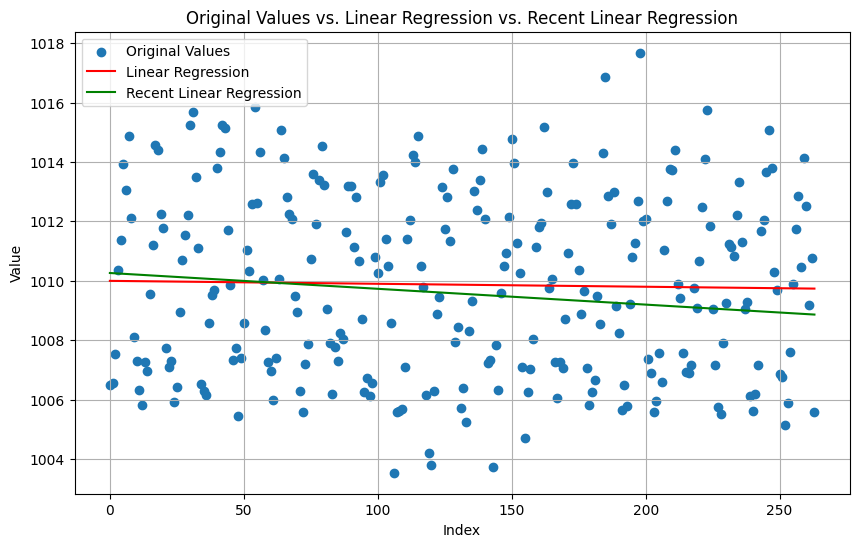

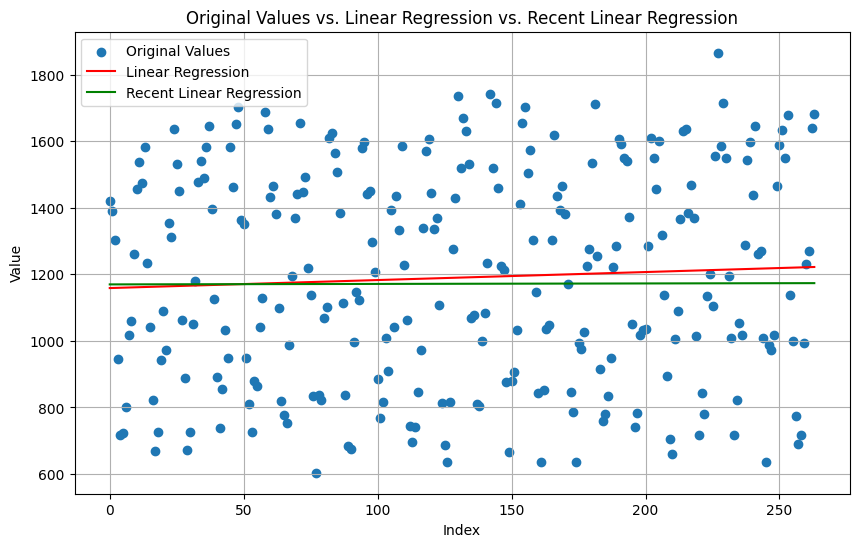

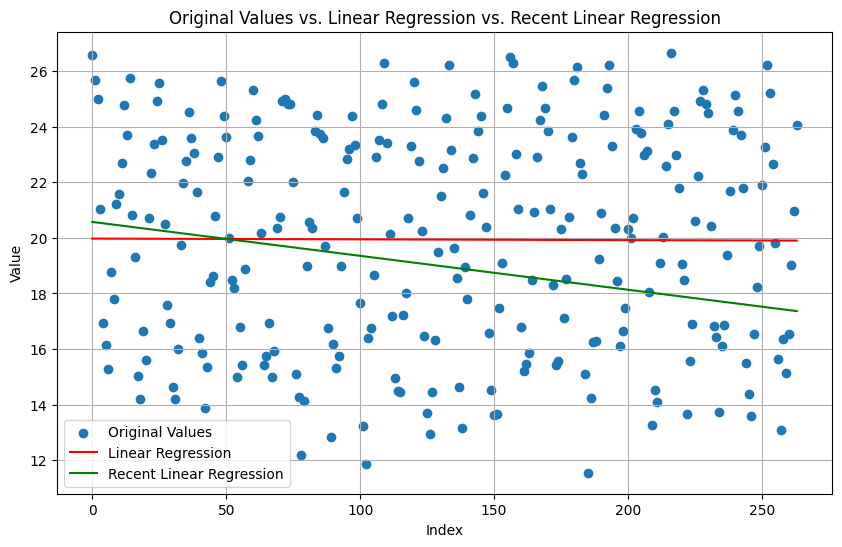

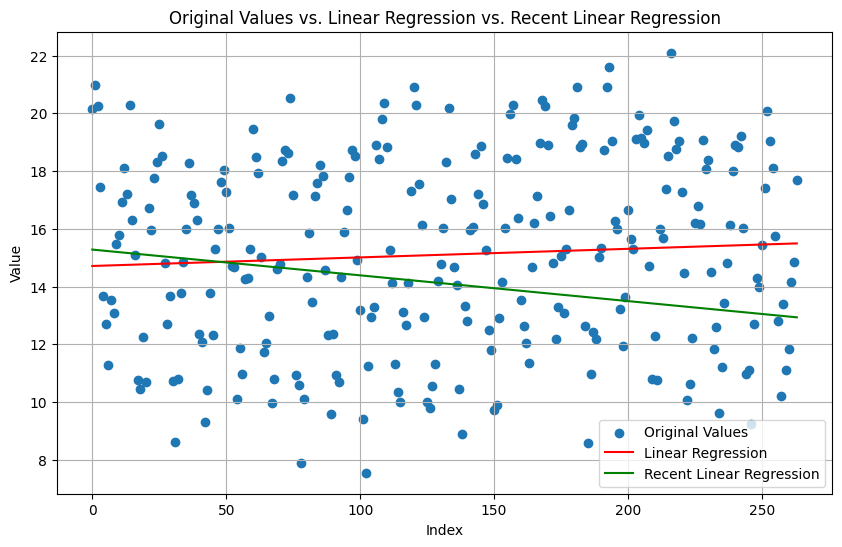

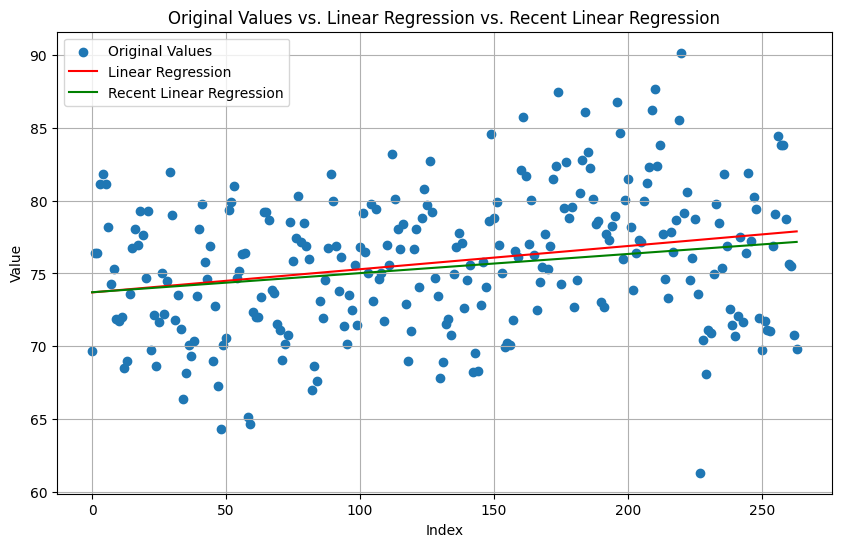

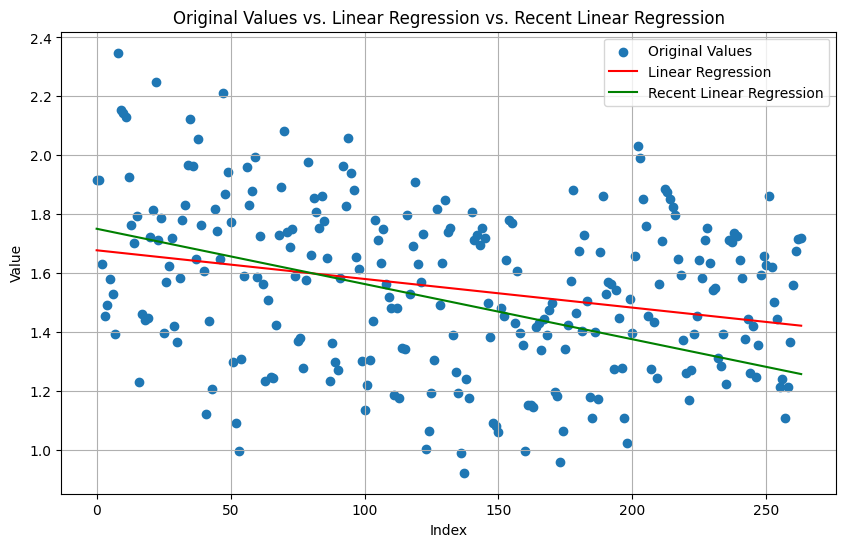

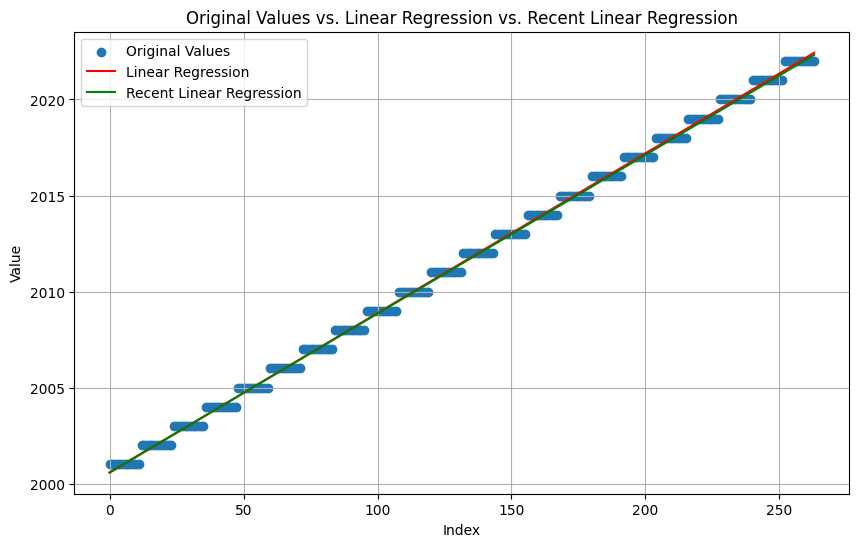

,Ano,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Year
0,2001,2.882098,1007.738405,1264.155491,24.572300,19.703538,75.910681,1.729273,2001.000000
1,2001,2.458285,1008.710016,1123.437702,22.642309,18.413180,78.347208,1.644432,2001.000000
2,2001,2.277784,1009.936426,1012.203940,21.050908,17.033860,79.136273,1.588556,2001.000000
3,2001,2.143525,1010.726048,940.534654,19.667593,15.755059,79.392322,1.574011,2001.000000
4,2001,1.807771,1011.800565,904.617728,18.640451,14.631761,78.905991,1.543012,2001.000000
...,...,...,...,...,...,...,...,...,...
259,2022,1.410757,1011.466631,1147.109700,17.500897,13.050561,77.226018,1.473291,2021.980331
260,2022,1.425557,1010.316887,1275.691322,18.825443,13.929853,75.461002,1.549679,2021.986821
261,2022,1.436442,1009.761024,1337.146179,19.573501,14.454208,74.662726,1.586867,2021.989698
262,2022,1.394681,1009.583084,1415.774806,20.187124,14.793416,73.583713,1.608730,2021.991370


In [8]:
df = read_csv_replace_missing_by_polynomial('rio_grande_do_sul_variacao_climatica.csv', 0, 1)
df.rename(columns={'Date': 'Ano'}, inplace=True)
df['Ano'] = df['Ano'].str[:4].astype(int)
df.drop(columns='State', inplace=True)
df

In [9]:
import re

df_indexed = df.set_index('Ano')

def correct_index(df):
    new_index = []
    for i, index_value in enumerate(df.index):
        new_index.append(f"{index_value}-{i % 12 + 1}")
    df.index = new_index
    return df

df_indexed = correct_index(df_indexed)
df_indexed = df_indexed.drop('Year', axis=1)
df_indexed

,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s)
2001-1,2.882098,1007.738405,1264.155491,24.572300,19.703538,75.910681,1.729273
2001-2,2.458285,1008.710016,1123.437702,22.642309,18.413180,78.347208,1.644432
2001-3,2.277784,1009.936426,1012.203940,21.050908,17.033860,79.136273,1.588556
2001-4,2.143525,1010.726048,940.534654,19.667593,15.755059,79.392322,1.574011
2001-5,1.807771,1011.800565,904.617728,18.640451,14.631761,78.905991,1.543012
...,...,...,...,...,...,...,...
2022-8,1.410757,1011.466631,1147.109700,17.500897,13.050561,77.226018,1.473291
2022-9,1.425557,1010.316887,1275.691322,18.825443,13.929853,75.461002,1.549679
2022-10,1.436442,1009.761024,1337.146179,19.573501,14.454208,74.662726,1.586867
2022-11,1.394681,1009.583084,1415.774806,20.187124,14.793416,73.583713,1.608730


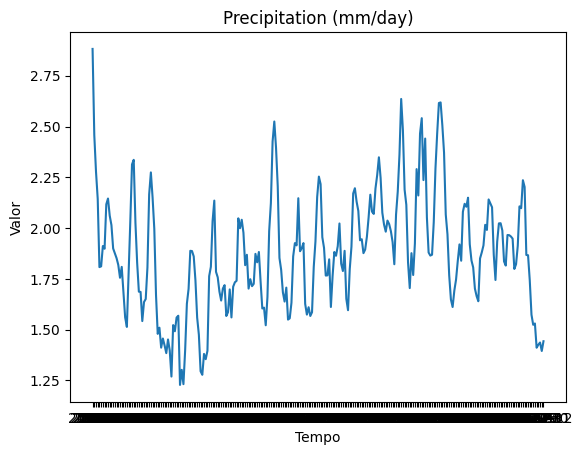

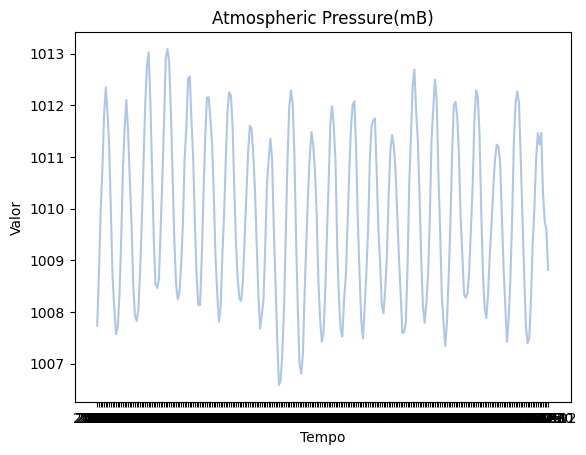

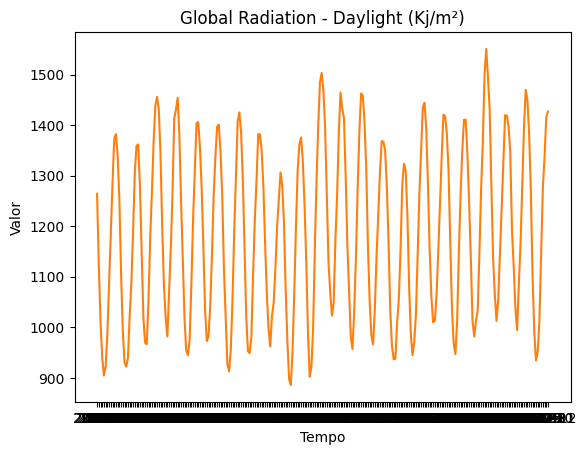

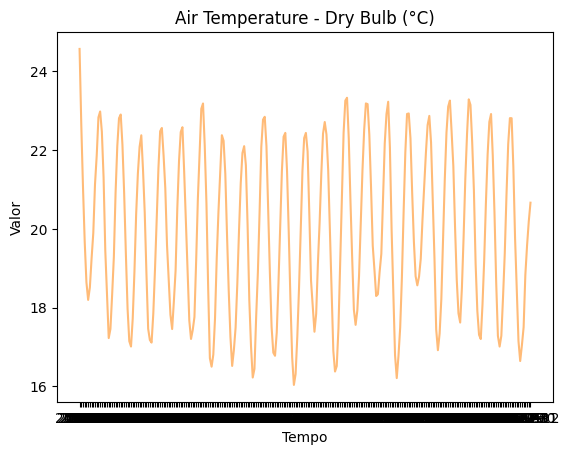

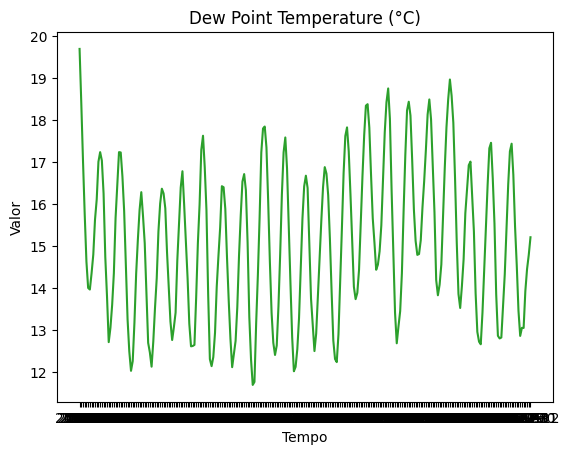

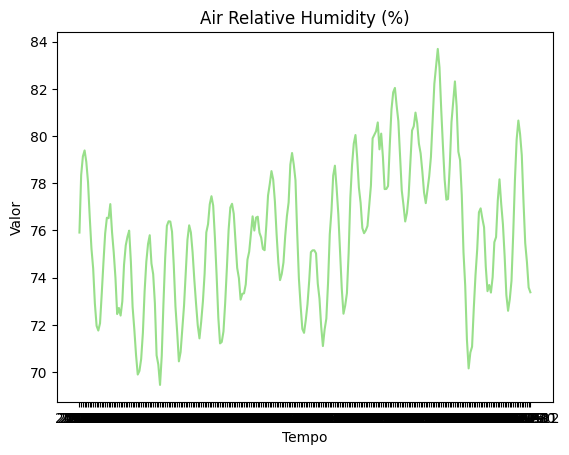

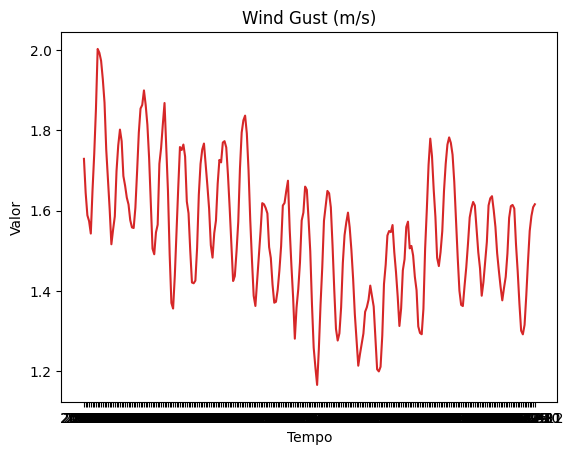

In [10]:
plot_columns(df_indexed)

In [11]:
df_indexed.to_csv('2003_mo_meteo.csv')

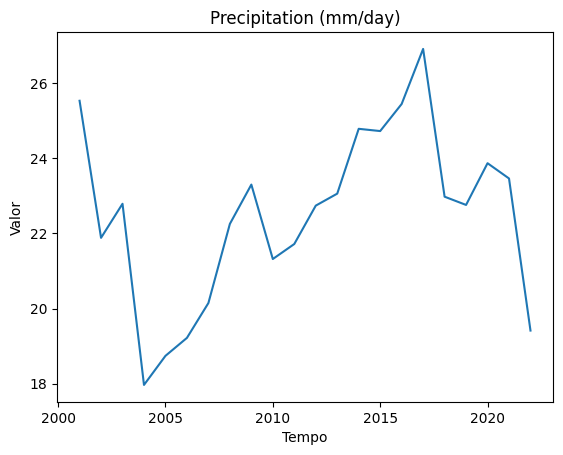

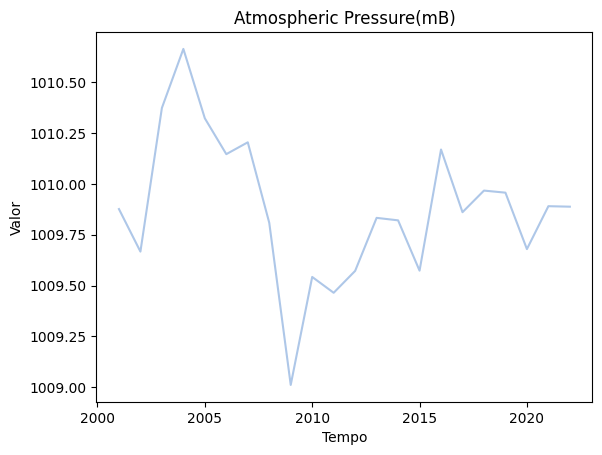

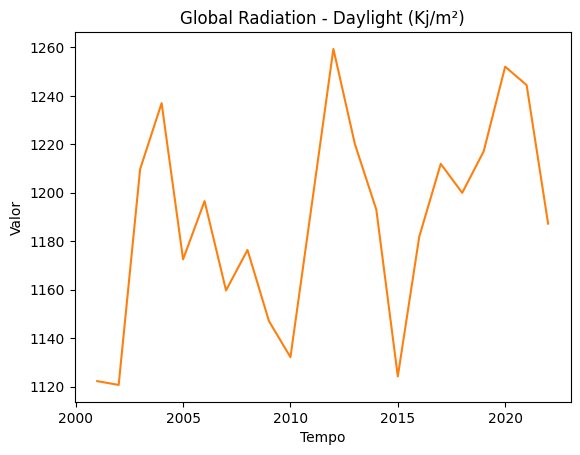

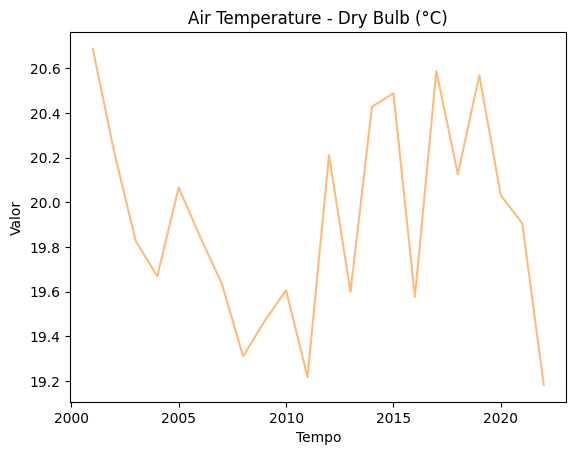

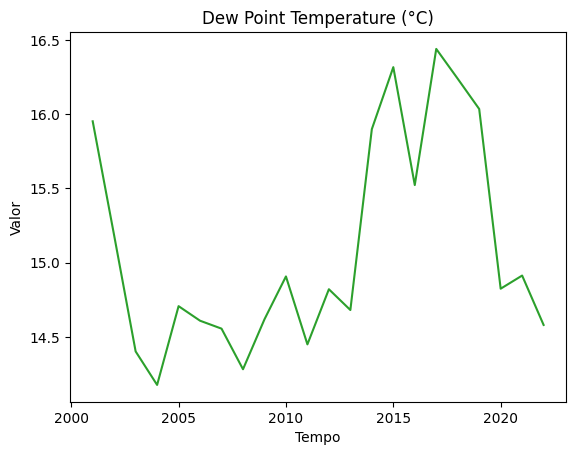

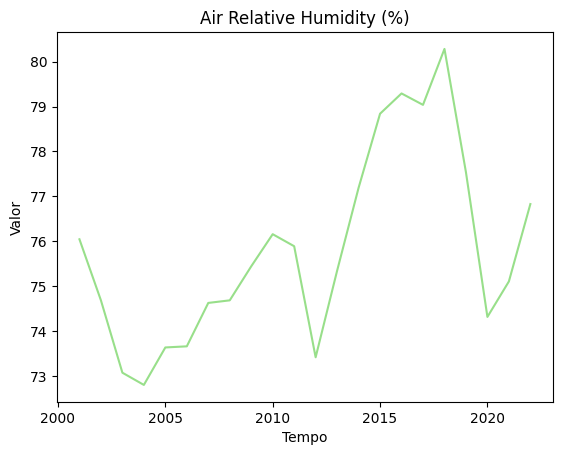

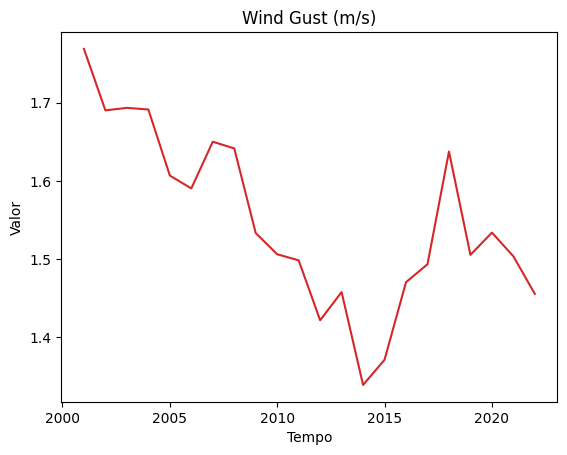

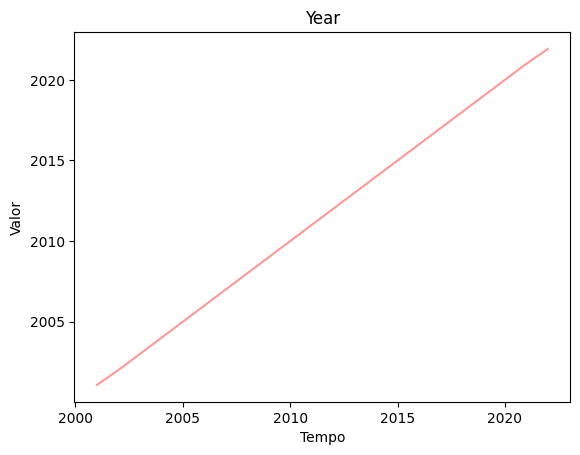

In [12]:
df_year = df.copy()
df_year.set_index('Ano', inplace=True)
df_year = df_year.groupby('Ano').mean()
df_year['Precipitation (mm/day)'] = df_year['Precipitation (mm/day)'] * 12
plot_columns(df_year)

In [13]:
df_2003 = df_year[df_year.index >= 2003]
df_2003

,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Year
Ano,,,,,,,,
2003,22.788399,1010.373673,1209.777445,19.826429,14.402032,73.076056,1.693311,2003.000006
2004,17.969121,1010.663952,1236.987340,19.668300,14.176408,72.804048,1.691200,2004.000000
2005,18.742591,1010.322652,1172.526172,20.066565,14.706917,73.637858,1.606753,2005.000000
2006,19.220567,1010.146471,1196.566993,19.844461,14.608862,73.662910,1.590203,2006.000000
2007,20.147928,1010.204712,1159.707297,19.637000,14.555503,74.629151,1.649981,2007.000000
2008,22.252836,1009.808828,1176.394779,19.309614,14.281948,74.686572,1.641433,2008.000000
2009,23.298793,1009.011533,1147.035612,19.467760,14.618425,75.443563,1.533149,2009.000000
2010,21.318925,1009.542526,1132.153043,19.606081,14.907113,76.158799,1.506009,2010.000000
2011,21.718194,1009.464689,1195.503726,19.216861,14.449600,75.891242,1.498239,2011.000000


In [14]:
df_2003.to_csv('2003_01_meteo.csv', index=True)

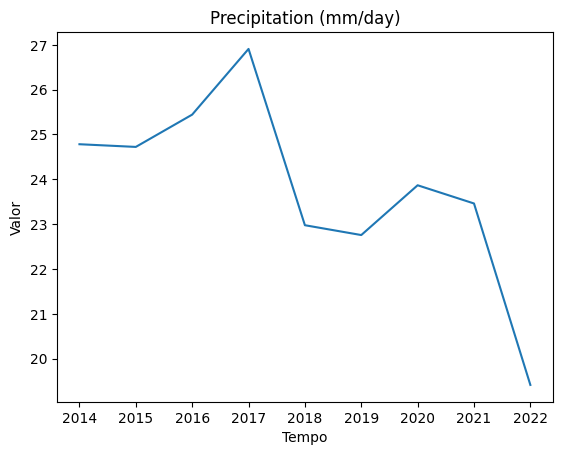

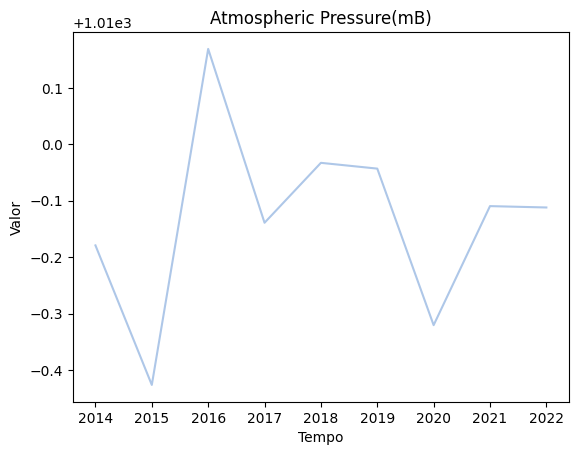

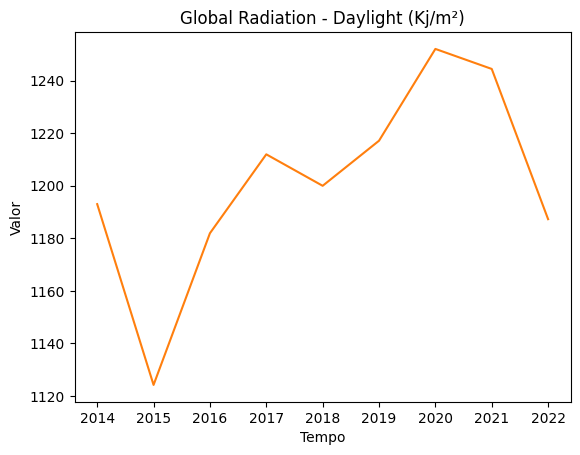

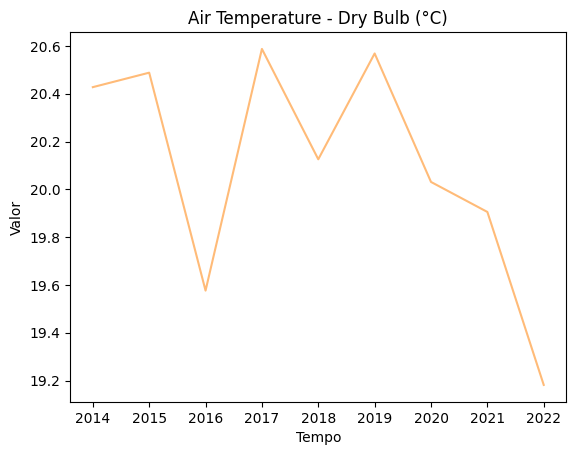

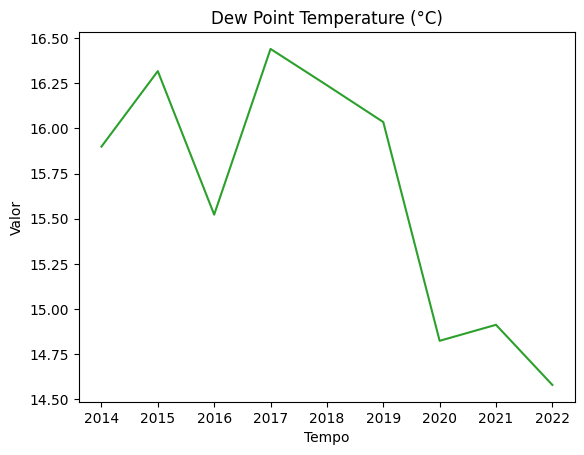

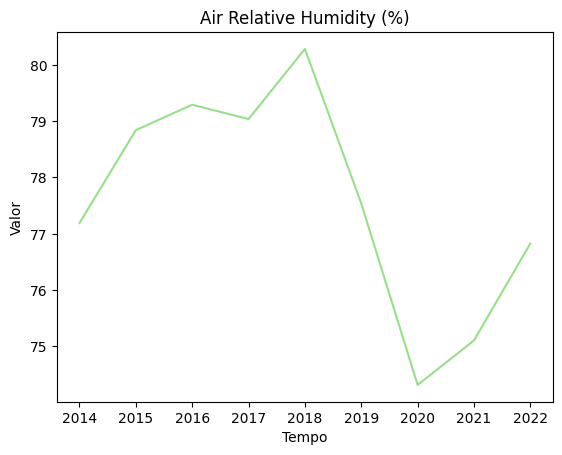

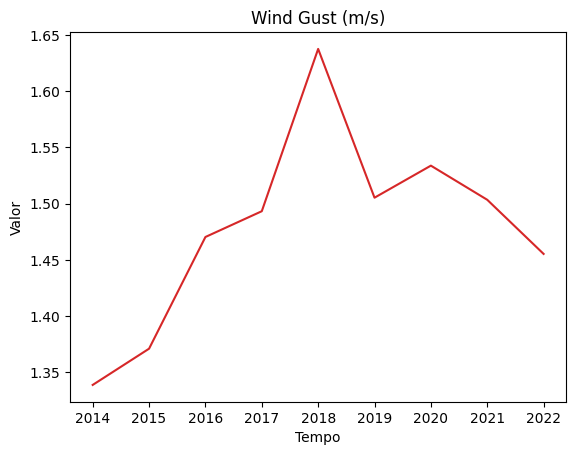

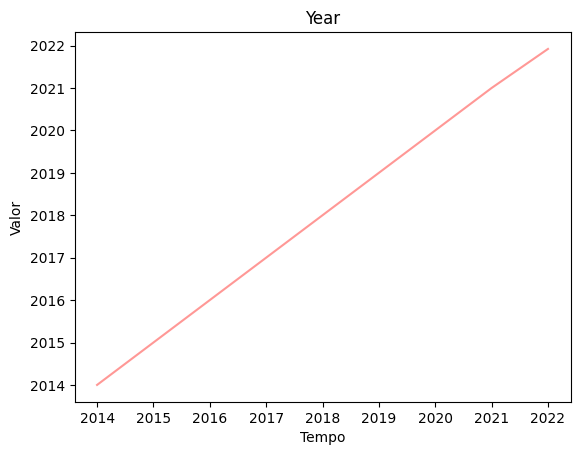

,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Year
Ano,,,,,,,,
2014,24.782579,1009.820897,1192.996822,20.427448,15.899206,77.190940,1.338879,2014.000000
2015,24.722732,1009.573495,1124.210775,20.488015,16.316845,78.840048,1.371075,2015.000000
2016,25.442954,1010.169235,1181.915413,19.576239,15.522793,79.291616,1.470329,2016.000000
2017,26.908008,1009.861015,1211.940423,20.587393,16.439649,79.037320,1.493229,2017.000000
2018,22.976635,1009.967265,1199.965133,20.125618,16.238805,80.282442,1.637443,2018.000000
2019,22.757320,1009.957025,1217.112647,20.568417,16.035057,77.538504,1.505247,2019.000000
2020,23.867538,1009.679463,1252.041361,20.030847,14.824541,74.317699,1.533730,2020.000000
2021,23.461311,1009.890523,1244.424176,19.905292,14.913066,75.107515,1.503389,2021.000000
2022,19.415148,1009.888109,1187.263177,19.181645,14.580391,76.829326,1.455285,2021.920844


In [15]:
df_2014 = df_year[df_year.index >= 2014]
plot_columns(df_2014)
df_2014

In [16]:
df_2014.to_csv('2014_01_meteo.csv', index=True)

In [17]:
df_2008 = df_year[df_year.index >= 2008]
df_2008

,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Year
Ano,,,,,,,,
2008,22.252836,1009.808828,1176.394779,19.309614,14.281948,74.686572,1.641433,2008.000000
2009,23.298793,1009.011533,1147.035612,19.467760,14.618425,75.443563,1.533149,2009.000000
2010,21.318925,1009.542526,1132.153043,19.606081,14.907113,76.158799,1.506009,2010.000000
2011,21.718194,1009.464689,1195.503726,19.216861,14.449600,75.891242,1.498239,2011.000000
2012,22.739123,1009.572250,1259.365040,20.210965,14.820933,73.419301,1.421608,2012.000000
2013,23.058116,1009.833123,1220.139468,19.598188,14.680917,75.345604,1.457626,2013.000000
2014,24.782579,1009.820897,1192.996822,20.427448,15.899206,77.190940,1.338879,2014.000000
2015,24.722732,1009.573495,1124.210775,20.488015,16.316845,78.840048,1.371075,2015.000000
2016,25.442954,1010.169235,1181.915413,19.576239,15.522793,79.291616,1.470329,2016.000000


In [18]:
df_2008.to_csv('2008_01_meteo.csv', index=True)